# Visualizing Honeybee models in Jupyter notebooks

This notebook demonstrates the visualization functions `plot_honeybee_model` and `plot_honeybee_models` for inline rendering Honeybee models directly within a Jupyter environment.

**Inputs**

* Official Honeybee-schema sample models fetched dynamically from GitHub
* Core Honeybee libraries (`honeybee.model.Model`) for geometry parsing and data handling


## Load remote Honeybee-schema sample models

This cell dynamically fetches all `.hbjson` models from the official Honeybee-schema GitHub repository and loads them into memory as Honeybee `Model` objects.


In [1]:
import requests
import json
import os, logging, warnings, traceback
from honeybee.model import Model
from contextlib import redirect_stdout, redirect_stderr


# Honeybee-schema sample/model directory URL
GITHUB_API_URL = "https://api.github.com/repos/ladybug-tools/honeybee-schema/contents/samples/model"
RAW_BASE_URL = "https://raw.githubusercontent.com/ladybug-tools/honeybee-schema/master/samples/model/"

def list_hbjson_files():
    """List all .hbjson files in the honeybee-schema sample/model directory via GitHub API."""
    resp = requests.get(GITHUB_API_URL)
    resp.raise_for_status()
    data = resp.json()
    return [item["name"] for item in data if item["name"].endswith(".hbjson")]

def fetch_hbjson_dict(filename):
    """Fetch and parse a Honeybee-schema sample model into a Python dict."""
    url = RAW_BASE_URL + filename
    resp = requests.get(url)
    resp.raise_for_status()
    return json.loads(resp.text)

def load_remote_honeybee_samples():
    """Fetch all Honeybee-schema sample models and load them into Honeybee Model objects."""
    filenames = list_hbjson_files()
    print(f"Found {len(filenames)} remote HBJSON files in the honeybee-schema samples directory.")

    sample_models, invalid_models = [], []

    for fname in filenames:
        try:
            hbjson_dict = fetch_hbjson_dict(fname)

            # Suppress Honeybee logging/warnings
            with open(os.devnull, "w") as devnull, redirect_stdout(devnull), redirect_stderr(devnull):
                prev_disable = logging.root.manager.disable
                logging.disable(logging.CRITICAL)
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        model = Model.from_dict(hbjson_dict)
                finally:
                    logging.disable(prev_disable)

        except Exception as e:
            invalid_models.append({
                "filename": fname,
                "error": str(e),
                "tb": traceback.format_exc()
            })
            continue
        else:
            sample_models.append(model)

    print(f"Loaded {len(sample_models)} valid models, skipped {len(invalid_models)} invalid files.")
    if invalid_models:
        print("Skipped files (short errors):")
        for it in invalid_models:
            print(f" - {it['filename']}")
            print(f"     {it['error']}")

    return sample_models

# Example usage:
sample_models = load_remote_honeybee_samples()
print(f"Successfully fetched {len(sample_models)} Honeybee models.")


Found 22 remote HBJSON files in the honeybee-schema samples directory.
Loaded 22 valid models, skipped 0 invalid files.
Successfully fetched 22 Honeybee models.


## plot_honeybee_model

### Plot first Honeybee model with default settings

This cell demonstrates the basic usage of the `plot_honeybee_model` function using one of the sample Honeybee models fetched from the Honeybee-schema repository. The function visualizes the model’s geometry directly inside the Jupyter notebook, displaying rooms, faces, apertures, and shading surfaces in 3D.


In [2]:
from plot_honeybee_model import plot_honeybee_model

example_model = sample_models[19]

plot_honeybee_model(example_model)


### Plot multiple Honeybee models with customized visualization

This cell illustrates how to plot several Honeybee models using the `plot_honeybee_model` function with customized visualization parameters. Instead of relying on defaults, specific surface types and visual properties are defined to emphasize interior and exterior structure.

**Inputs**

* `some_sample_models`: a subset of two Honeybee models selected from the fetched samples (`sample_models[8:10]`)
* Visualization options:

  * `title=None`: disables automatic plot titles
  * `show_wireframe=True`: overlays the geometric wireframe for structural clarity
  * `surface_opacity=0.5`: sets translucent surfaces for improved depth perception
  * `show_legend=True`: displays color mapping of surface types
  * `include_types=('ceiling', 'interior_floor', 'exterior_wall', 'interior_wall', 'aperture', 'air_wall')`: restricts the visualization to key building components

For more options see the python file `plot_honeybee_model.py` in the same directory.


In [3]:
some_sample_models = sample_models[8:10]
for i in some_sample_models:
    plot_honeybee_model(i, title=None, show_wireframe=True, surface_opacity=1, show_legend=True, include_types=('ceiling', 'interior_floor', 'exterior_wall', 'interior_wall', 'aperture', 'air_wall'))

## plot_honeybee_models

### Plot multiple Honeybee models in a grid

This cell uses the `plot_honeybee_models` function to visualize multiple Honeybee models in a single static 3D scene. It provides an overview of several sample geometries fast at once, allowing for comparative inspection of their spatial configurations.

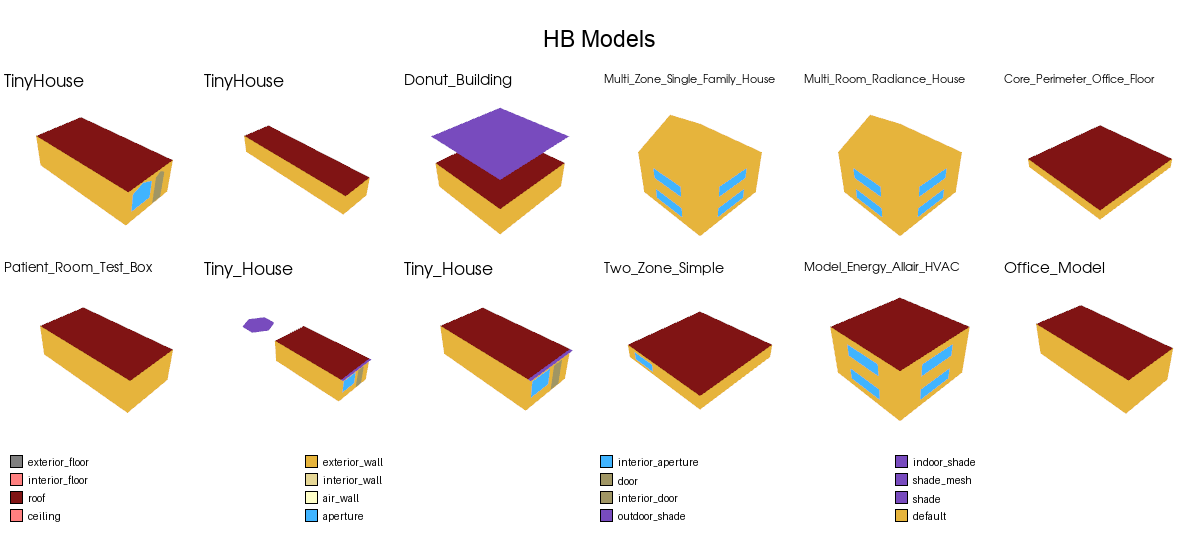

In [9]:
from plot_honeybee_models import plot_honeybee_models

plot_honeybee_models(sample_models, main_title="HB Models")

### Plot all Honeybee models in a wireframe grid layout

This cell visualizes all fetched Honeybee models simultaneously using the `plot_honeybee_models` function with a grid-based layout and wireframe styling. The setup provides a compact overview of multiple models with consistent camera settings and a clean white background.

**Inputs**

* `models=sample_models`: list of Honeybee models loaded from the Honeybee-schema repository
* Visualization parameters:

  * `main_title="Wireframe HB Models"`: sets a global title for the composite figure
  * `grid=(5,2)`: arranges plots in a 5×2 grid (automatically adjusted if needed)
  * `figsize=(640, 420)`: defines the size of each subplot in pixels
  * `total_width=1200`: overall plot width for layout scaling
  * `base_model_height=600`: reference model height for consistent scene proportions
  * `plot_main_legend=False`: hides the global legend to maintain a clean layout
  * `camera_zoom=1.3`: adjusts the initial camera distance for better framing
  * `surface_opacity=0`: hides solid faces to emphasize edges only
  * `show_wireframe=True`: displays structural wireframes for clarity
  * `background_color="white"`: ensures high-contrast visualization
  * `aspectmode="data"`: keeps consistent aspect ratios across all subplots

For more options see the python file `plot_honeybee_models.py` in the same directory.


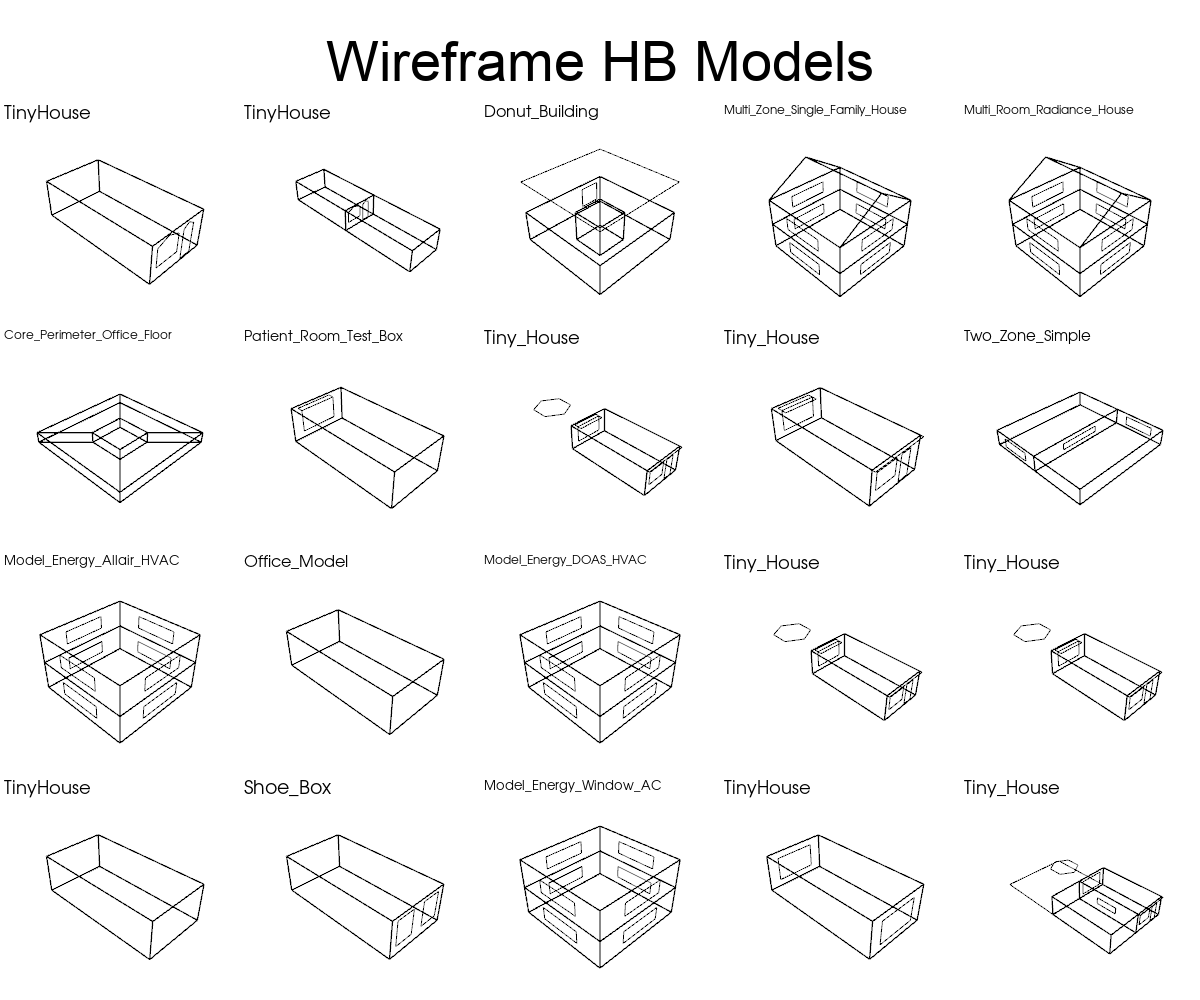

In [5]:
plot_honeybee_models(
    models=sample_models,
    main_title="Wireframe HB Models",
    grid=(5,4),
    total_width=1200,
    base_model_height=600,
    plot_main_legend=False,
    camera_zoom=1.3,
    surface_opacity=0,
    show_wireframe=True,
    background_color="white",
    aspectmode="data",
)

## Exporting plots

### Export single Honeybee model to interactive HTML

This cell exports a single Honeybee model visualization as an interactive HTML file. The figure is first generated using `plot_honeybee_model()` with wireframe and legend enabled, then written to disk for standalone viewing.


In [6]:
fig = plot_honeybee_model(example_model, show_wireframe=True, show_legend=True, show=False)
fig.write_html("example_model.html")
print(f"Wrote example_model.html")

Wrote example_model.html


### Export multiple Honeybee models to static image

This cell saves a composite visualization of several Honeybee models as a static PNG image. The layout and rendering are managed by `plot_honeybee_models()`, allowing easy sharing of a scene overview.

In [10]:
img = plot_honeybee_models(sample_models, main_title="HB Models", show=False)
img.save("hbmodels.png")
print(f"Saved hbmodels.png")

Context leak detected, msgtracer returned -1


Saved hbmodels.png
